### trying out functions 

In [1]:
import numpy as np 
import matplotlib
import matplotlib.pyplot as plt

from Utils_python import llh2localxy
from Utils_python import remove_polygon
#from Utils_python import quadtree_regular
#from Utils_python import quadtree_irregular

In [4]:
def fit_bilinplane(data, coord):
    # Clean data and coordinates of NaNs, update coordinate vector accordingly:
    no_nan_ind = np.where(~np.isnan(data))[0]
    d = data[no_nan_ind]
    coord = coord[:, no_nan_ind]

    # Get the number of data points
    N = len(d)

    # If 3 or more data points are left after NaN screening, then
    if N >= 3:
        # Make matrix G
        ones = np.ones(N)
        G = np.vstack((ones, coord[0, :], coord[1, :])).T
        gtginv = inv(np.dot(G.T, G))

        m = np.dot(gtginv, np.dot(G.T, d))

        # Calculate the rms
        rootms = np.sqrt(np.mean((d - np.dot(G, m))**2))
    else:
        rootms = 0
        G = 0
        m = np.array([0, 0, 0])

    return m, G, rootms






In [5]:
### Following are how to run the different function 

In [2]:
# Sample latitude, longitude in decimal degrees
# Each column represents a data point
llh = np.array([[34.05, 34.10, 34.15],  # Latitude values
                [-118.24, -118.20, -118.10]])  # Longitude values

# Latitude of origin in decimal degrees
ll_org = np.array([34.10, -118.20])

# Call the llh2localxy function
xy = llh2localxy(llh, ll_org)

# Print the result
print("Local XY Coordinates (in km):")
print(xy)

Local XY Coordinates (in km):
[[-3.70344969 -5.54602705]
 [-0.          0.        ]
 [ 9.24777988  5.54607278]]


In [3]:
import matplotlib
#matplotlib.use('TkAgg')

# Create a sample array (replace this with your actual data)
array = np.random.rand(100, 100)

# Define the bounding box for the polygon (xmin, xmax, ymin, ymax)
xmin = 20
xmax = 80
ymin = 30
ymax = 70

# Call the function to remove the polygon from the array
#remove_polygon.remove_polygon_from_array(array, xmin, xmax, ymin, ymax)

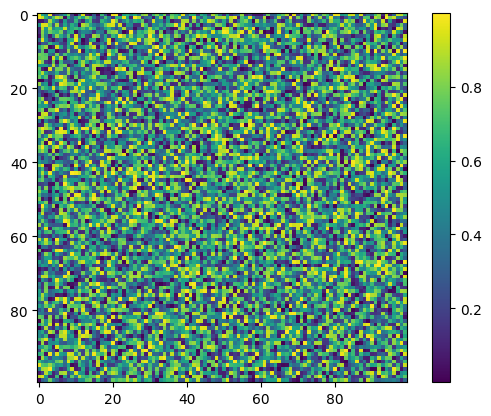

In [4]:
%matplotlib inline

plt.imshow(array)
plt.colorbar()

In [5]:

# Define your input data, tolerance, and fittype
data = array  # Replace with your data
tolerance = 0.1  # Set your tolerance value
fittype = 1  # Set your fittype (1 for median, 2 for bilinear plane)

# Call the quadtree_part function
#indmat, sqval, cx, cy, cntp, nlin = quadtree_regular.quadtree_part(data, tolerance, fittype)



In [31]:
startlevel=3
maxdim=9
tolerance = .1
fittype = 1

lin, col = data.shape

# Adjust data size to be a power of 2
dim = 1
condition = max([lin, col])
while condition > 2 ** dim:
    dim = dim + 1
print(dim)

nlin = 2 ** dim
ncol = nlin

dataexp = np.full((nlin, ncol), np.nan)
dataexp[0:lin, 0:col] = data

# Initialize the quadtree index matrix
indmat = np.array([[1, 0, 10, 0, 0],
                   [2, 0, 10, 0, 0],
                   [3, 0, 10, 0, 0],
                   [4, 0, 10, 0, 0]])



7


In [32]:
def quadtree_level(oldind):
    '''
    Add a new quadtree partitioning level
    '''
    lin, col = oldind.shape
    nlin = 1
    
    # Loop over every old quadtree partition
    for k in range(lin):
        
        if oldind[k, col - 4] == 1:  # If deeper part isn't needed, we add a 0
            tmp1 = np.concatenate((oldind[k, :col - 4], [0]))
            tmp2 = oldind[k, col - 4:]
            
            add_indexmatrix = np.column_stack((tmp1, tmp2))
            nlin += 1
        else:  # Deeper partition needed, we add three new lines to the matrix
            tmp1 = np.column_stack((np.tile(oldind[k, :col - 4], (4, 1)), np.array([1, 2, 3, 4])))
            tmp2 = np.column_stack((np.zeros((4, 1)), np.tile(oldind[k, col - 3:], (4, 1))))

            add_indexmatrix = np.column_stack((tmp1, tmp2))
            nlin += 4

        if k == 0: 
            indexmatrix = np.empty((0, add_indexmatrix.shape[1]))
            
        indexmatrix = np.vstack((indexmatrix, add_indexmatrix))
        
    return indexmatrix


def check_quadtree(oldindmat, data, tolerance, fittype):
    ilin, icol = oldindmat.shape

    for k in range(ilin):
        if oldindmat[k, icol - 4] == 0:
            print(f'index = ',oldindmat[k, :].shape)
            print(data.shape)
            chunck = getchunck(oldindmat[k, :], data)
            
            c1, c2 = np.where(~np.isnan(chunck) | (chunck == 0))
            chunck = chunck.flatten()
            chunck_noNaN = chunck[c1 * chunck.shape[1] + c2]

            if len(chunck_noNaN) >= chunck.size / 2:
                if fittype == 2 and len(chunck_noNaN) >= 3:
                    m, _, rms = fit_bilinplane(chunck_noNaN, np.column_stack((c1, c2)))
                    medvalue = np.median(chunck_noNaN)
                    m = np.array([medvalue, 0, 0])
                elif fittype == 1:
                    medvalue = np.median(chunck_noNaN)
                    tmp = np.ones_like(chunck_noNaN) * medvalue
                    dif = chunck_noNaN - tmp
                    rms = np.sqrt(np.mean(dif ** 2))
                    m = np.array([medvalue, 0, 0])
                else:
                    meanvalue = np.mean(chunck_noNaN)
                    tmp = np.ones_like(chunck_noNaN) * meanvalue
                    dif = chunck_noNaN - tmp
                    rms = np.sqrt(np.mean(dif ** 2))
                    m = np.array([meanvalue, 0, 0])

                if rms <= tolerance:
                    oldindmat[k, icol - 3:icol] = np.array([1, *m])
                else:
                    oldindmat[k, icol - 3:icol] = np.array([0, *m])
            elif len(chunck_noNaN) < 1:
                oldindmat[k, icol - 3:icol] = np.array([1, np.nan, np.nan, np.nan])
            else:
                oldindmat[k, icol - 3:icol] = np.array([0, np.nan, np.nan, np.nan])

    newindmat = oldindmat.copy()
    return newindmat

def getchunck(index, data):
    # Get length of real index values, the last three values are
    # to be assigned with the median or something else, the fourth
    # last value is the 'check' signal
    length = len(index) - 4
    print(length)
    # Get size of data
    lin, col = data.shape

    # Get number of lines, or blocksize
    blcksz = lin
    print(f'blcksz= ',blcksz)
    # Initialize
    lst = 1
    cst = 1

    # Loop over every column of the 'real' part of the index matrix
    for k in range(length):
        blcksz = blcksz / 2
        if index[k] == 1:
            lst = lst
            cst = cst
        elif index[k] == 2:
            lst = lst
            cst = cst + blcksz
        elif index[k] == 3:
            lst = lst + blcksz
            cst = cst + blcksz
        elif index[k] == 4:
            lst = lst + blcksz
            cst = cst

    # Pick out the chunk:
    chunk = data[lst-1:lst+blcksz-1, cst-1:cst+blcksz-1]

    return chunk

# Add levels to the index matrix if startlevel is greater than 1
if startlevel > 1:
    for k in range(2, startlevel + 1):
        nindmat = quadtree_level(indmat)
        indmat = nindmat
print(indmat.shape)
        
# Loop over each k in 2^k
for k in range(startlevel, maxdim + 1):
    newindmat = check_quadtree(indmat, dataexp, tolerance, fittype)
    che = newindmat[:, -4]

    # If any zeros in check-column, perform further partitioning
    if np.prod(che) == 0:
        indmat = quadtree_level(newindmat)
    else:
        k = maxdim

print(indmat.shape)

(64, 7)
index =  (7,)
(128, 128)
3
blcksz=  128


TypeError: slice indices must be integers or None or have an __index__ method

In [9]:
print(indmat.shape)

(4, 5)


In [12]:
np.arange(2,10)

array([2, 3, 4, 5, 6, 7, 8, 9])